<a href="https://colab.research.google.com/github/vivekdevulapalli07/TEM_Difp/blob/main/diffraction_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install mp_api

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.diffraction.tem import TEMCalculator
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

In [6]:
def get_diffraction_pattern(material_id, zone_axis, api_key=None, voltage=200):
    """
    Retrieves a structure from Materials Project and generates a TEM diffraction pattern
    for a specific zone axis.

    Args:
        material_id (str): The Materials Project ID (e.g., 'mp-149')
        zone_axis (list): The zone axis as a list of three integers [h, k, l]
        api_key (str, optional): Your Materials Project API key. If None, uses environment variable.
        voltage (float, optional): Electron beam energy in keV. Default is 200 keV.

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects with the diffraction pattern
    """
    # Convert zone axis to tuple of integers
    zone_axis = tuple(map(int, zone_axis))

    # Get the structure from Materials Project
    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Retrieved structure: {structure.formula}")

    # Create TEM calculator
    tem_calculator = TEMCalculator(voltage=voltage, beam_direction=zone_axis)

    # Generate the diffraction pattern
    pattern = tem_calculator.get_pattern(structure)

    # Create figure for the diffraction pattern
    fig, ax = plt.subplots(figsize=(10, 10))

    # Extract pattern data from the DataFrame
    pattern_data = pattern.to_dict('records')

    # Scale factor for spot sizes
    intensities = [dot['Intensity (norm)'] for dot in pattern_data]
    max_intensity = max(intensities) if intensities else 1
    scale_factor = 200 / max_intensity

    # Plot the diffraction spots
    for dot in pattern_data:
        # Skip the direct beam for now (it will be added separately)
        hkl = dot['(hkl)']
        if hkl == '(0, 0, 0)':
            continue

        # Extract position
        x, y = dot['Position']
        intensity = dot['Intensity (norm)']

        # Plot the spot
        ax.scatter(x, y, s=intensity*scale_factor, c='black')

        # Label the spots with their Miller indices
        # Convert to string first, then extract digits and minus signs safely
        hkl_str = ''.join(c for c in str(hkl) if c.isdigit() or c == '-')
        ax.text(x, y+0.05, hkl_str, ha='center', fontsize=8)

    # Add a central spot (direct beam)
    ax.scatter(0, 0, s=200, c='black', marker='o')
    ax.text(0, 0.02, '000', ha='center', fontsize=8)

    # Set plot limits
    max_range = 4  # Default range
    if pattern_data:
        x_coords = [dot['Position'][0] for dot in pattern_data]
        y_coords = [dot['Position'][1] for dot in pattern_data]
        if x_coords and y_coords:
            max_coord = max(max(abs(np.array(x_coords))), max(abs(np.array(y_coords))))
            max_range = max_coord * 1.2

    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # Add labels and title
    ax.set_xlabel('Distance (cm)')
    ax.set_ylabel('Distance (cm)')
    ax.set_title(f'TEM Diffraction Pattern for {structure.formula}\nZone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig, ax, pattern

In [2]:
def get_diffraction_pattern_from_cif(cif_file, zone_axis, voltage=200):
    """
    Generates a TEM diffraction pattern from a local CIF file for a specific zone axis.

    Args:
        cif_file (str): Path to the CIF file
        zone_axis (list): The zone axis as a list of three integers [h, k, l]
        voltage (float, optional): Electron beam energy in keV. Default is 200 keV.

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects with the diffraction pattern
    """
    # Convert zone axis to tuple of integers
    zone_axis = tuple(map(int, zone_axis))

    # Load structure from CIF file
    structure = Structure.from_file(cif_file)
    print(f"Loaded structure from file: {structure.formula}")

    # Create TEM calculator
    tem_calculator = TEMCalculator(voltage=voltage, beam_direction=zone_axis)

    # Generate the diffraction pattern
    pattern = tem_calculator.get_pattern(structure)

    # Create figure for the diffraction pattern
    fig, ax = plt.subplots(figsize=(10, 10))

    # Extract pattern data
    pattern_data = pattern.to_dict('records')

    # Scale factor for spot sizes
    intensities = [dot['Intensity (norm)'] for dot in pattern_data]
    max_intensity = max(intensities) if intensities else 1
    scale_factor = 200 / max_intensity

    # Plot the diffraction spots
    for dot in pattern_data:
        # Skip the direct beam for now (it will be added separately)
        hkl = dot['(hkl)']
        if hkl == '(0, 0, 0)':
            continue

        # Extract position
        x, y = dot['Position']
        intensity = dot['Intensity (norm)']

        # Plot the spot
        ax.scatter(x, y, s=intensity*scale_factor, c='black')

        # Label the spots with their Miller indices
        # Convert to string first, then extract digits and minus signs safely
        hkl_str = ''.join(c for c in str(hkl) if c.isdigit() or c == '-')
        ax.text(x, y+0.05, hkl_str, ha='center', fontsize=8)

    # Add a central spot (direct beam)
    ax.scatter(0, 0, s=200, c='black', marker='o')
    ax.text(0, 0.02, '000', ha='center', fontsize=8)

    # Set plot limits
    max_range = 4  # Default range
    if pattern_data:
        x_coords = [dot['Position'][0] for dot in pattern_data]
        y_coords = [dot['Position'][1] for dot in pattern_data]
        if x_coords and y_coords:
            max_coord = max(max(abs(np.array(x_coords))), max(abs(np.array(y_coords))))
            max_range = max_coord * 1.2

    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # Add labels and title
    ax.set_xlabel('Distance (cm)')
    ax.set_ylabel('Distance (cm)')
    cif_name = cif_file.split('/')[-1].split('.')[0]
    ax.set_title(f'TEM Diffraction Pattern for {cif_name}\nZone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig, ax, pattern

In [3]:
def download_and_save_cif(material_id, api_key=None, output_file=None):
    """
    Downloads a CIF file from Materials Project and saves it locally.

    Args:
        material_id (str): The Materials Project ID (e.g., 'mp-149')
        api_key (str, optional): Your Materials Project API key. If None, uses environment variable.
        output_file (str, optional): Path to save the CIF file. If None, uses material_id.cif

    Returns:
        str: Path to the saved CIF file
    """
    if output_file is None:
        output_file = f"{material_id}.cif"

    # Get the structure from Materials Project
    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Retrieved structure: {structure.formula}")

        # Save as CIF
        structure.to(filename=output_file)
        print(f"Saved CIF file to: {output_file}")

    return output_file

In [4]:

def generate_multiple_patterns(material_id, api_key=None, voltage=200, zone_axes=None):
    """
    Generates multiple diffraction patterns for a material with different zone axes.

    Args:
        material_id (str): The Materials Project ID (e.g., 'mp-149')
        api_key (str, optional): Your Materials Project API key. If None, uses environment variable.
        voltage (float, optional): Electron beam energy in keV. Default is 200 keV.
        zone_axes (list, optional): List of zone axes to use. If None, uses common axes.

    Returns:
        matplotlib figure with multiple diffraction patterns
    """
    if zone_axes is None:
        zone_axes = [[0,0,1], [1,1,0], [1,1,1], [1,0,0]]

    # Get the structure from Materials Project
    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Exploring diffraction patterns for {structure.formula}")

    # Create a figure with subplots for each zone axis
    rows = int(np.ceil(len(zone_axes) / 2))
    cols = min(2, len(zone_axes))
    fig, axs = plt.subplots(rows, cols, figsize=(15, 7.5 * rows))

    # Handle single subplot case
    if len(zone_axes) == 1:
        axs = np.array([axs])

    # Flatten the axes array for easier indexing
    axs = axs.flatten()

    for i, zone_axis in enumerate(zone_axes):
        # Convert zone axis to tuple
        zone_axis_tuple = tuple(zone_axis)

        # Create TEM calculator for this zone axis
        tem_calculator = TEMCalculator(voltage=voltage, beam_direction=zone_axis_tuple)

        # Generate the diffraction pattern
        pattern = tem_calculator.get_pattern(structure)

        # Extract pattern data from the DataFrame
        pattern_data = pattern.to_dict('records')

        # Scale factor for spot sizes
        intensities = [dot['Intensity (norm)'] for dot in pattern_data]
        max_intensity = max(intensities) if intensities else 1
        scale_factor = 100 / max_intensity

        # Plot the diffraction spots
        for dot in pattern_data:
            if dot['(hkl)'] == '(0, 0, 0)':
                continue

            x, y = dot['Position']
            intensity = dot['Intensity (norm)']

            axs[i].scatter(x, y, s=intensity*scale_factor, c='black')

            # Label significant spots
            if intensity > 0.3:
                # Convert to string first, then extract digits and minus signs safely
                hkl_str = ''.join(c for c in str(dot['(hkl)']) if c.isdigit() or c == '-')
                axs[i].text(x, y+0.05, hkl_str, ha='center', fontsize=8)

        # Add a central spot (direct beam)
        axs[i].scatter(0, 0, s=200, c='black', marker='o')

        # Set plot limits
        # Calculate appropriate plot limits based on spot positions
        if pattern_data:
            x_coords = [dot['Position'][0] for dot in pattern_data]
            y_coords = [dot['Position'][1] for dot in pattern_data]
            if x_coords and y_coords:
                max_coord = max(max(abs(np.array(x_coords))), max(abs(np.array(y_coords))))
                max_range = max_coord * 1.2
                axs[i].set_xlim(-max_range, max_range)
                axs[i].set_ylim(-max_range, max_range)
            else:
                axs[i].set_xlim(-4, 4)
                axs[i].set_ylim(-4, 4)
        else:
            axs[i].set_xlim(-4, 4)
            axs[i].set_ylim(-4, 4)

        # Add labels and title
        axs[i].set_title(f'Zone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
        axs[i].set_aspect('equal')
        axs[i].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle(f'TEM Diffraction Patterns for {structure.formula}', fontsize=16, y=1.02)

    return fig, axs


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved structure: Si2


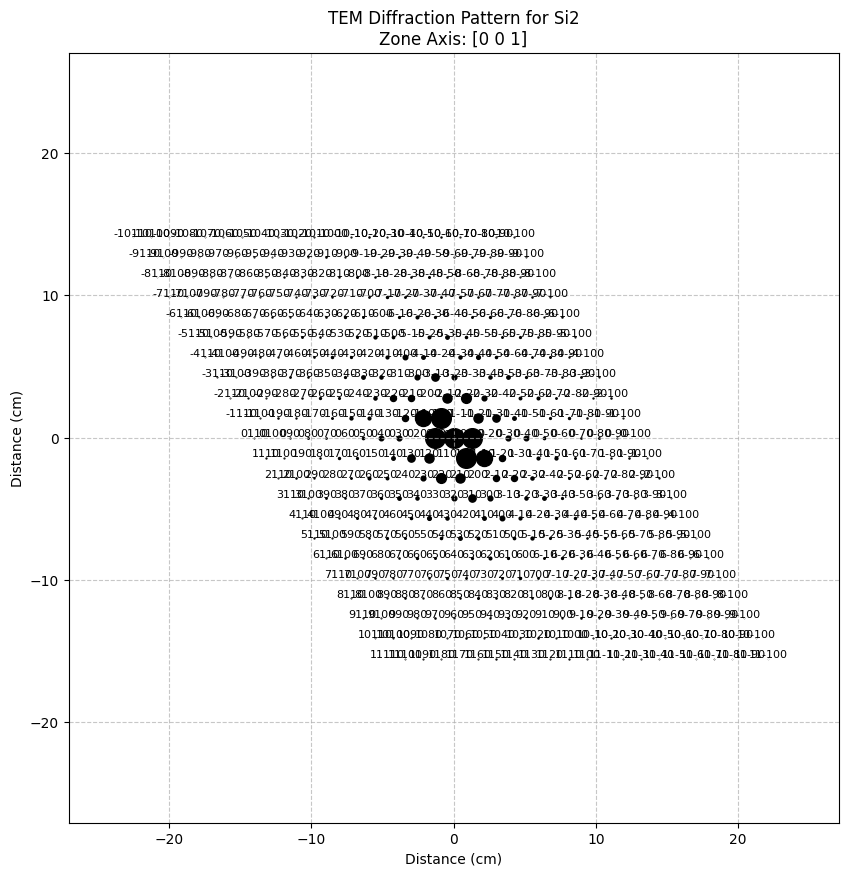

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Exploring diffraction patterns for Si2


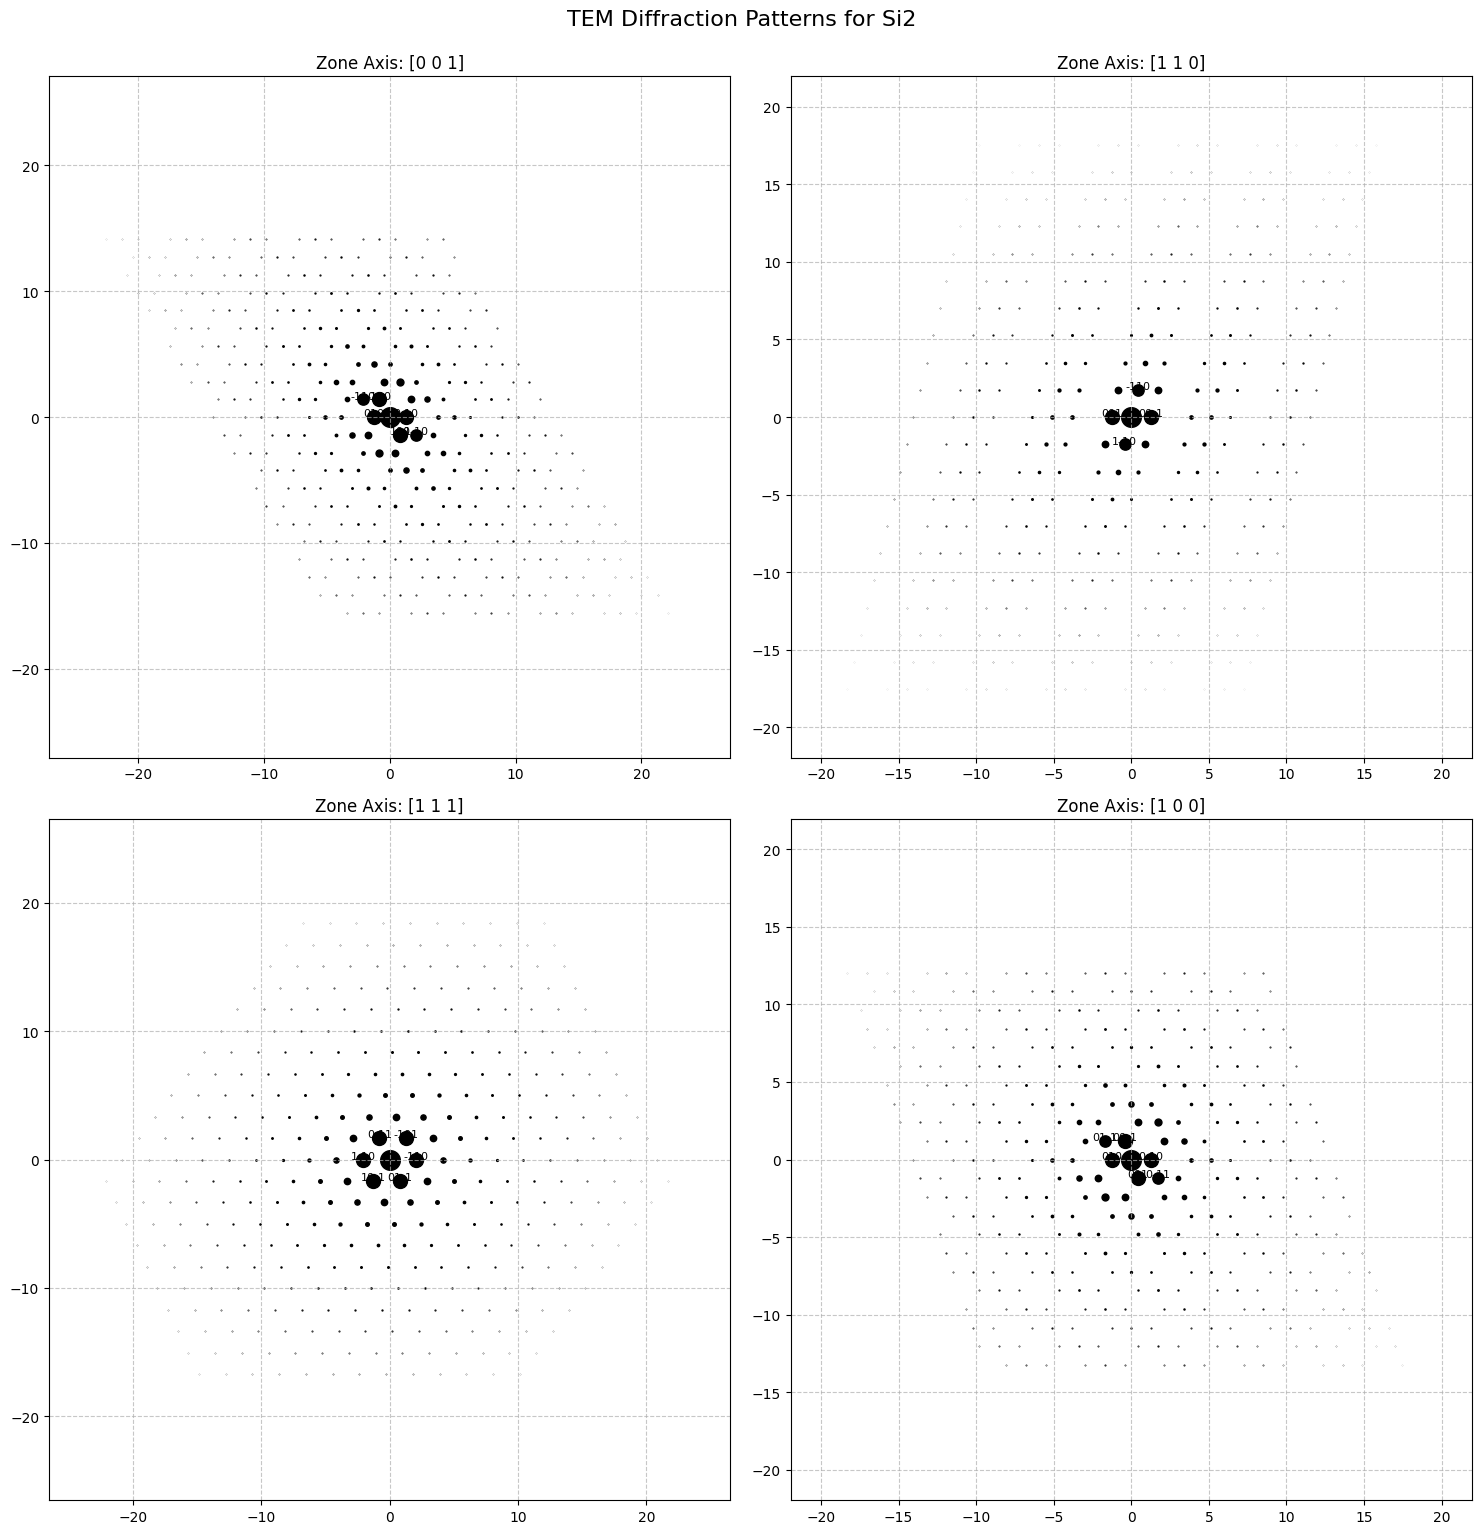

In [7]:
# Example usage
if __name__ == "__main__":
    # Example 1: Get diffraction pattern directly from Materials Project
    material_id = "mp-149"  # Silicon
    zone_axis = [0, 0, 1]   # [001] zone axis
    api_key = "daOUQsZxLXFDwpCXnB0uBMoXiicXZ8nq"  # Replace with your Materials Project API key

    fig, ax, pattern = get_diffraction_pattern(material_id, zone_axis, api_key)
    plt.show()

    # Optionally save the figure
    fig.savefig(f"{material_id}_zone_{zone_axis[0]}{zone_axis[1]}{zone_axis[2]}.png", dpi=300)

    # Example 2: Generate multiple diffraction patterns
    fig2, axs = generate_multiple_patterns(material_id, api_key)
    plt.show()
    fig2.savefig(f"{material_id}_multiple_zones.png", dpi=300, bbox_inches='tight')